In [256]:
import pandas as pd
import plotly.express as px
from etl import get_data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid") 

import warnings
warnings.filterwarnings('ignore')


In [257]:
supermarket = get_data('data')
supermarket.sample(5)

,Company,ReceiptDate,ReceiptNumber,CashierNumber,TransactionNumber,Cashier,ArticleNumber,Item,Quantity,Amount,Discount
18581,"Супермаркет ""РосМаг""",2024-08-18,107000,7,T007000,Ермакова Антонина Геннадиевна,2020,Йогурт питьевой,1,58.830002,20
900,"Супермаркет ""РосМаг""",2024-01-11,102563,10,T002563,Новиков Леон Ааронович,2015,Бананы,1,71.470001,0
12121,"Супермаркет ""РосМаг""",2024-05-30,105795,1,T005795,Беляева Кира Владиславовна,2006,Масло подсолнечное,2,212.350006,10
18669,"Супермаркет ""РосМаг""",2024-08-19,106211,3,T006211,Громов Василий Фокич,2002,Хлеб 'Бородинский',1,25.559999,5
22378,"Супермаркет ""РосМаг""",2024-10-04,103461,7,T003461,Бобылева Елена Ильинична,2019,Творог,1,118.500000,20


- Таблица представляет собой данные о чеках в супермаркете "РосМаг". В таблице есть следующие столбцы:

1. Company: Название компании или супермаркета (все записи принадлежат "РосМаг").
2. ReceiptDate: Дата чека
3. ReceiptNumber: Номер чека
4. CashierNumber: Номер кассы
5. TransactionNumber: Номер транзакции
6. Cashier: Имя кассира, который провел транзакцию
7. ArticleNumber: Код товара, который был куплен
8. Item: Наименование товара
9. Quantity: Количество единиц товара
10. Amount: Сумма за товар без учета скидки
11. Discount: Скидка на товар 

<Axes: >

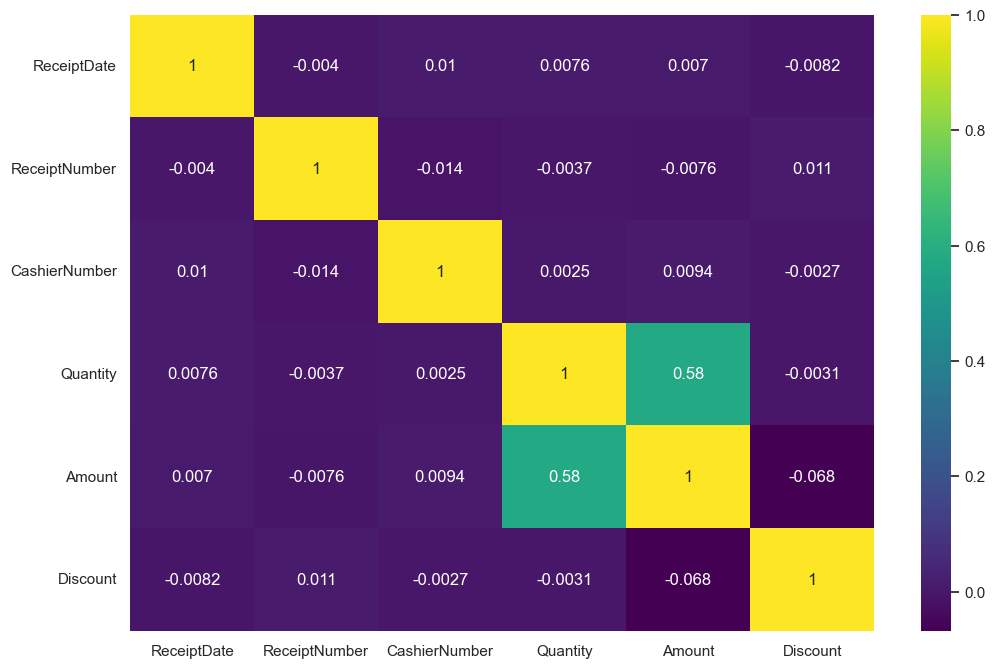

In [258]:
plt.figure(figsize=(12, 8))
sns.heatmap(supermarket.select_dtypes(exclude=['object']).corr(), annot=True, cmap='viridis')

 - В данных нет сильных взаимосвязей между большинством переменных, за исключением количества и суммы, что логично(но и там связь малая). Это может говорить о том что данные были сгенерированы

---
### Анализ временных данных

In [259]:
supermarket['DayOfWeek'] = supermarket['ReceiptDate'].dt.weekday + 1

- Добавляю новый столбец DayOfWeek в таблицу, который покажет день покупки исходя из даты

In [260]:
date_data= (
    supermarket.groupby('ReceiptDate')
    .agg(
        day_of_week=('DayOfWeek', 'first'), 
        check_count=('ReceiptNumber', 'nunique'), 
        total_sum=('Amount', 'sum'), 
        total_quantity=('Quantity', 'sum')   
    ).reset_index())

In [261]:
by_weekday = (date_data.groupby('day_of_week')
    .agg(total_check_count=('check_count', 'sum'), total_quantity=('total_quantity', 'sum')).reset_index())

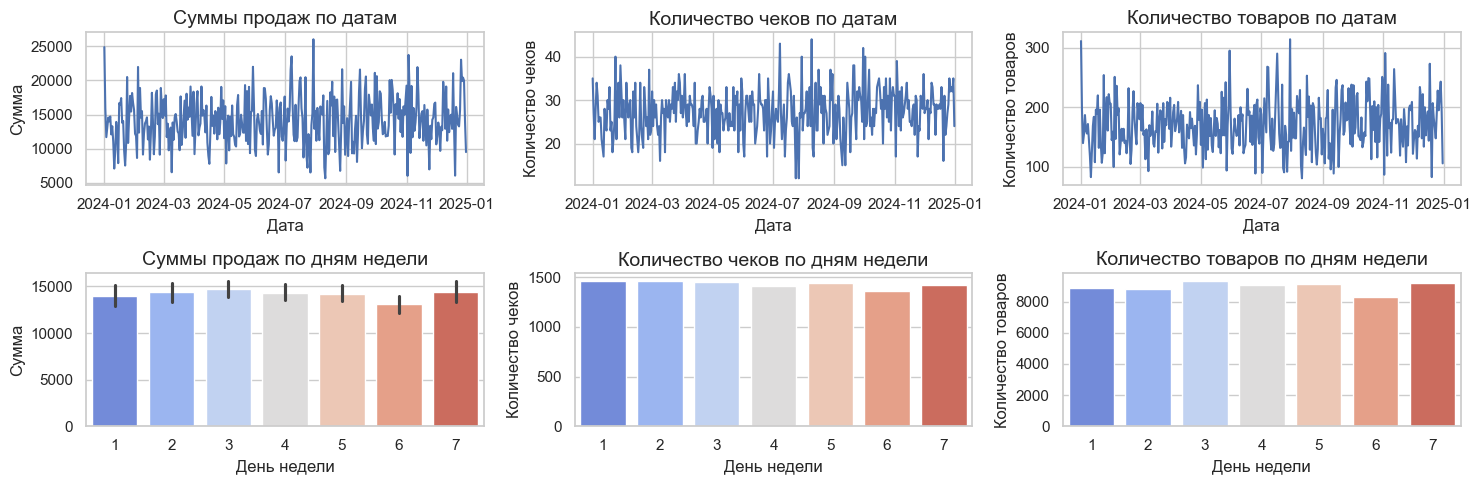

In [262]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

sns.lineplot(data=date_data, x='ReceiptDate', y='total_sum', ax=axes[0, 0])
axes[0, 0].set_title('Суммы продаж по датам', fontsize=14)
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Сумма')


sns.lineplot(data=date_data, x='ReceiptDate', y='check_count', ax=axes[0, 1])
axes[0, 1].set_title('Количество чеков по датам', fontsize=14)
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Количество чеков')


sns.lineplot(data=date_data, x='ReceiptDate', y='total_quantity', ax=axes[0, 2])
axes[0, 2].set_title('Количество товаров по датам', fontsize=14)
axes[0, 2].set_xlabel('Дата')
axes[0, 2].set_ylabel('Количество товаров')


sns.barplot(data=date_data, x='day_of_week', y='total_sum', ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_title('Суммы продаж по дням недели', fontsize=14)
axes[1, 0].set_xlabel('День недели')
axes[1, 0].set_ylabel('Сумма')


sns.barplot(data=by_weekday, x='day_of_week', y='total_check_count', ax=axes[1, 1], palette="coolwarm")
axes[1, 1].set_title('Количество чеков по дням недели', fontsize=14)
axes[1, 1].set_xlabel('День недели')
axes[1, 1].set_ylabel('Количество чеков')

sns.barplot(data=by_weekday, x='day_of_week', y='total_quantity', ax=axes[1, 2], palette="coolwarm")
axes[1, 2].set_title('Количество товаров по дням недели', fontsize=14)
axes[1, 2].set_xlabel('День недели')
axes[1, 2].set_ylabel('Количество товаров')

plt.tight_layout()
plt.show()


- Супермаркет имеет равномерный покупательский поток в течение недели. Нет заметных пиков в выходные или в начале недели. При стабильно одинаковых суммах продаж и количестве чеков можно сделать вывод, что покупатели делают покупки в аналогичных объемах на протяжении всей недели.

- Возможно, что магазин не использует сезонные или недельные тренды для максимизации прибыли.

In [263]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'


date_data['season'] = date_data['ReceiptDate'].apply(get_season)

season_analysis = (
    date_data.groupby('season')
    .agg(total_check_count=('check_count', 'sum')) 
    .reset_index()
)
season_analysis

,season,total_check_count
0,Autumn,2548
1,Spring,2490
2,Summer,2496
3,Winter,2466


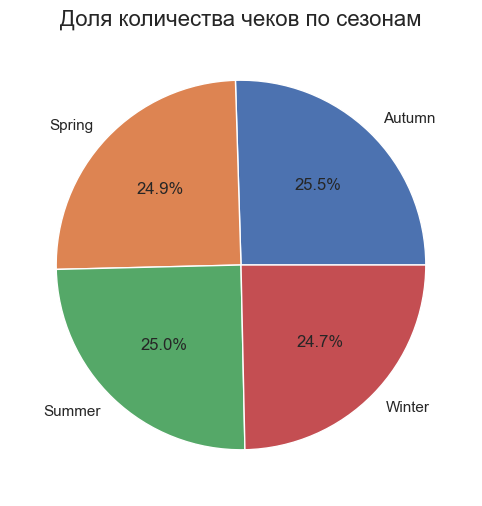

In [264]:
plt.figure(figsize=(8, 6))
plt.pie(season_analysis['total_check_count'], labels=season_analysis['season'], autopct='%1.1f%%')
plt.title('Доля количества чеков по сезонам', fontsize=16)
plt.show()

- Осень - сезон с наибольшим количеством чеков (2548), что говорит о  покупательской активности в этот период

- Остальные сезоны показывают схожие значения по количеству чеков, при этом весной и летом количество чеков почти одинаково (2490 и 2496), а зимой — немного меньше (2466). Зимой возможно меньшая активность покупателей из-за холодной погоды , когда покупатели могут делать покупки реже

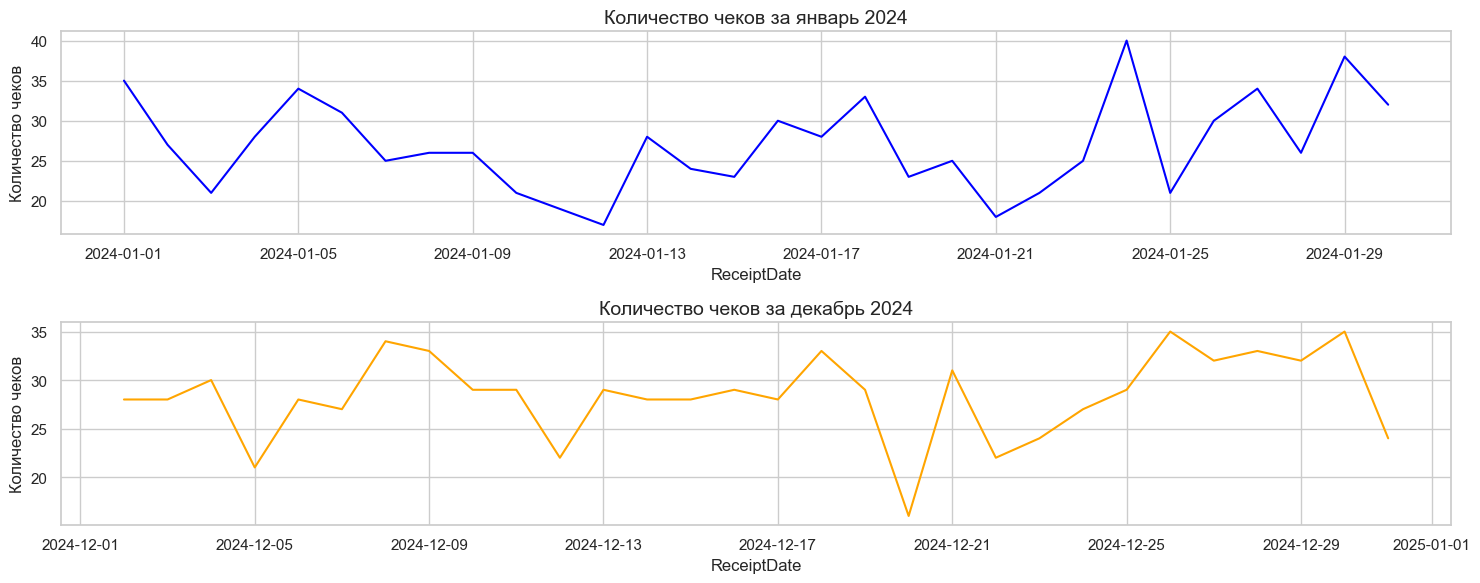

In [265]:
first = date_data.head(30)
last = date_data.tail(30)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))
sns.lineplot(data=first, x='ReceiptDate', y='check_count', ax=axes[0], color='blue')
axes[0].set_title('Количество чеков за январь 2024', fontsize=14)
axes[0].set_ylabel('Количество чеков')

sns.lineplot(data=last, x='ReceiptDate', y='check_count', ax=axes[1], color='orange')
axes[1].set_title('Количество чеков за декабрь 2024', fontsize=14)
axes[1].set_ylabel('Количество чеков')

plt.tight_layout()
plt.show()


- Количество чеков значительно колеблется, что говорит о нестабильности покупательской активности в январе. Это может быть связано с праздничным периодом(спад после новогодних праздников)
- В декабре заметны всплески активности ближе к концу месяца, что логично объясняется подготовкой к новогодним праздникам и увеличением трат


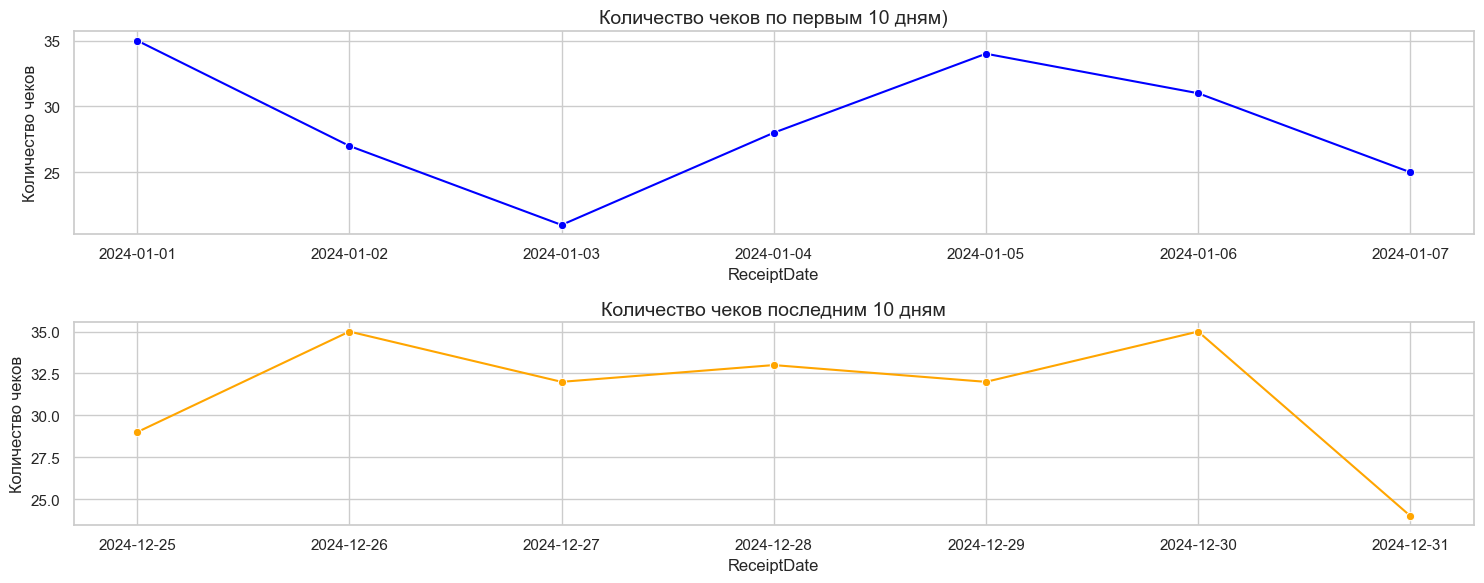

In [266]:
first = date_data.head(7)
last = date_data.tail(7)

fig, axes =  plt.subplots(2, 1, figsize=(15, 6))
sns.lineplot(data=first, x='ReceiptDate', y='check_count', ax=axes[0], marker='o', color='blue')
axes[0].set_title('Количество чеков по первым 10 дням)', fontsize=14)
axes[0].set_ylabel('Количество чеков')

sns.lineplot(data=last, x='ReceiptDate', y='check_count', ax=axes[1], marker='o', color='orange')
axes[1].set_title('Количество чеков последним 10 дням', fontsize=14)
axes[1].set_ylabel('Количество чеков')

plt.tight_layout()
plt.show()


-  В разресе первых дней года наблюдается спад количества чеков , после чего они начинают восстанавливаться. Это может быть связано с постпраздничным периодом, когда активность покупателей временно снижается.
- Но в посдедние дни можно заметить как возрастают количество чеков и становятся более стабильнее. В выходные дни (6 и 7 день недели) наблюдается спад, что может быть связано с завершением подготовки к праздникам.

---
## Топ по продуктам

In [267]:
grouped = supermarket.groupby(['DayOfWeek', 'Item'])['Quantity'].sum().reset_index()
top_products = grouped.loc[grouped.groupby('DayOfWeek')['Quantity'].idxmax()]
top_products

,DayOfWeek,Item,Quantity
2,1,Картофель,1276
22,2,Картофель,1254
42,3,Картофель,1542
62,4,Картофель,1384
82,5,Картофель,1570
102,6,Картофель,1335
122,7,Картофель,1451


- Самым продаваемым в неделе продуктом по количеству является Картошка, т к в столбце Quantity считается не кг или г, а штучно - логично что такого рода продуктов будут в выйгрыше

In [268]:
top_products2 = supermarket.groupby('DayOfWeek')['Item'].agg(most_frequent_item=lambda x: x.mode(),item_count='count').reset_index()
top_products2

,DayOfWeek,most_frequent_item,item_count
0,1,Молоко 'Домик в деревне',4366
1,2,Кофе молотый,4274
2,3,Йогурт питьевой,4385
3,4,Яблоки 'Белый налив',4237
4,5,Картофель,4265
5,6,Бананы,4026
6,7,Бананы,4238


Если смотреть в разрезе наиболее часто встречаещихся продуктов в неделе можно выявить :
- Основными товарами являются базовые продукты питания (молоко, картофель, бананы), а также полезные перекусы (йогурт, яблоки).
- Наиболее часто покупаемые товары отражают недельные привычки покупателей, связанные с домом, работой или выходными. Эти данные могут помочь в планировании запасов, акций или маркетинговых мероприятий, ориентированных на конкретные дни недели.

In [269]:
supermarket['price_per_unit'] = supermarket['Amount'] / supermarket['Quantity']

In [270]:
item_data = (supermarket.groupby('Item').agg(
        item_count=('Item', 'count'), 
        total_amount=('Amount', 'sum'),
        avg_price_per_unit=('Amount', lambda x: x.sum() / supermarket.loc[x.index, 'Quantity'].sum())).reset_index())

item_data['total_amount'] = item_data['total_amount'].round()
item_data['avg_price_per_unit'] = item_data['avg_price_per_unit'].round(2)

item_data['total_%'] =  item_data['total_amount']/item_data['total_amount'].sum()*100
item_data['total_%'] = item_data['total_%'].round(1)

item_data = item_data.sort_values(by=['item_count',  'avg_price_per_unit', 'total_amount'], ascending=False).head(5)
item_data

,Item,item_count,total_amount,avg_price_per_unit,total_%
0,Бананы,2034,247608.0,57.58,4.8
4,Кофе молотый,2022,658553.0,241.32,12.7
11,Молоко 'Домик в деревне',2020,161546.0,57.86,3.1
17,Чай черный,2006,396352.0,144.71,7.6
13,Сок апельсиновый,2005,266113.0,96.03,5.1


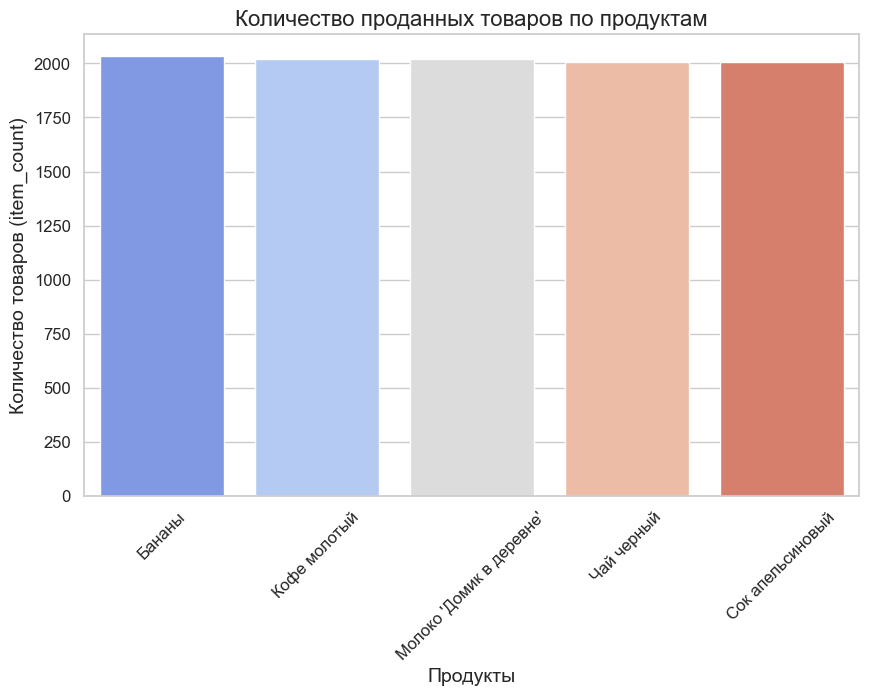

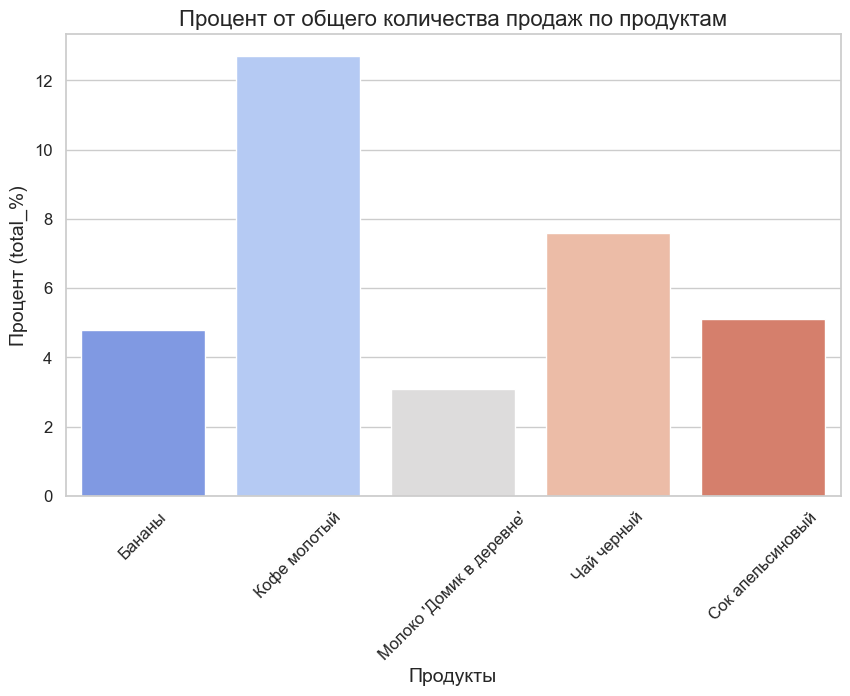

In [271]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Item', y='item_count', data=item_data, palette="coolwarm")
plt.title('Количество проданных товаров по продуктам', fontsize=16)
plt.xlabel('Продукты', fontsize=14)
plt.ylabel('Количество товаров (item_count)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Item', y='total_%', data=item_data, palette="coolwarm")
plt.title('Процент от общего количества продаж по продуктам', fontsize=16)
plt.xlabel('Продукты', fontsize=14)
plt.ylabel('Процент (total_%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- Товары с высокой средней ценой (кофе молотый) обеспечивают значительную долю выручки. Упор на рекламу дорогих товаров, таких как кофе или чай, может принести больше доход
- Более доступные товары (бананы, молоко) популярны по количеству, но их вклад в общую выручку ниже. Продвижение более доступных товаров (бананы, молоко) может стимулировать увеличение их продаж.

---
## Топ по кассам

In [272]:
cashier_num_data = (supermarket.groupby('CashierNumber').agg(check_count=('ReceiptNumber', 'nunique'), item_count=('Item', 'count'), top_item=('Item', lambda x: x.mode())).reset_index())
cashier_num_data = cashier_num_data.sort_values(by=['check_count'], ascending=False).head(5)
cashier_num_data

,CashierNumber,check_count,item_count,top_item
4,5,1030,3041,Чай черный
5,6,1017,3062,Бананы
8,9,1014,3011,Картофель
0,1,1003,2974,Йогурт питьевой
7,8,1003,2961,Сок апельсиновый


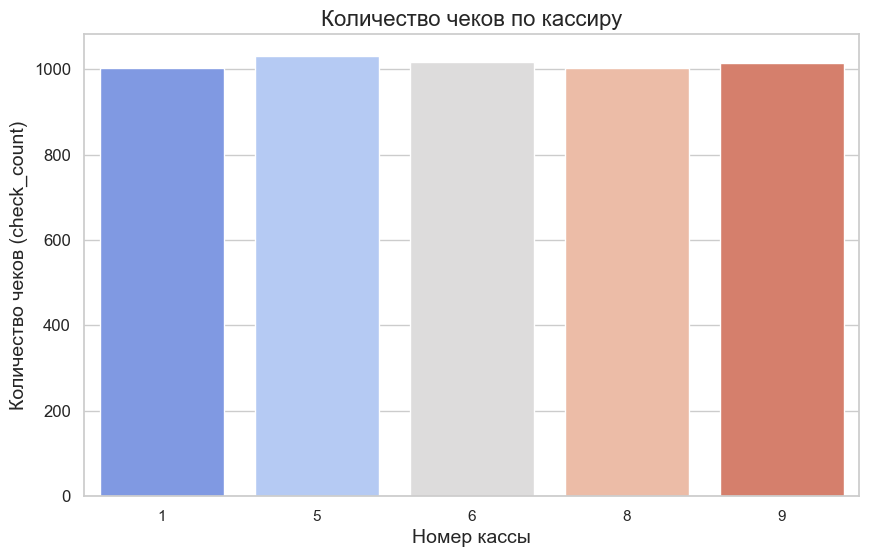

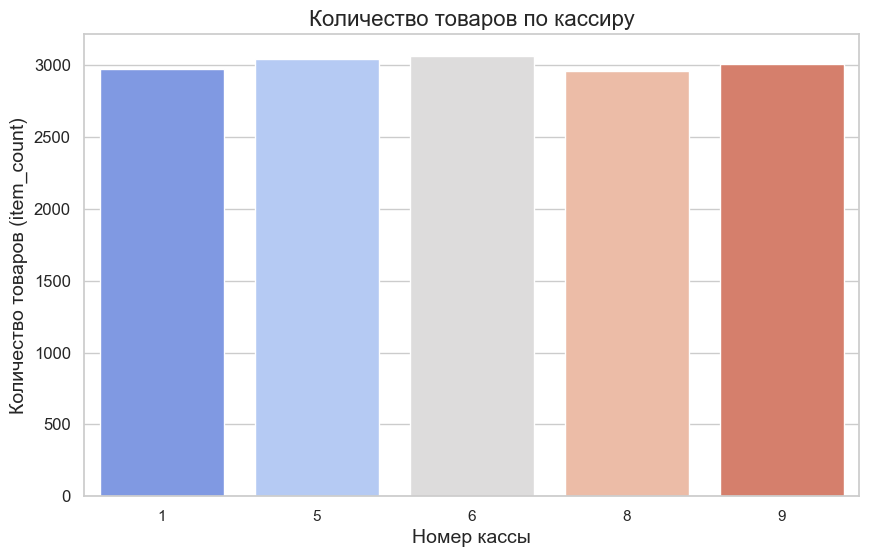

In [273]:
plt.figure(figsize=(10, 6))
sns.barplot(x='CashierNumber', y='check_count', data=cashier_num_data, palette="coolwarm")
plt.title('Количество чеков по кассиру', fontsize=16)
plt.xlabel('Номер кассы', fontsize=14)
plt.ylabel('Количество чеков (check_count)', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='CashierNumber', y='item_count', data=cashier_num_data, palette="coolwarm")
plt.title('Количество товаров по кассиру', fontsize=16)
plt.xlabel('Номер кассы', fontsize=14)
plt.ylabel('Количество товаров (item_count)', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

- Касса №5 и №6 выделяются по количеству чеков и товаров.
- Самые продаваемые товары на кассах различаются, что может быть связано с местоположением кассы или предпочтениями покупателей.
Можно предположить что кассы №5 и №6  могут быть ближе к входу или отделам с популярными товарами.
Кассы  №1 и №8 могут находиться в зонах, где покупатели завершают покупки.

Кассы, связанные с овощами и фруктами, логично расположить ближе к их отделам.
Кассы с напитками и быстрыми продуктами лучше размещать вблизи зон с высокой проходимостью.

---
## Анализ скидок

In [274]:
discount_data = (supermarket.groupby('Discount').agg(item_count=('Item', 'count'),total_amount=('Amount', 'sum')).reset_index())

discount_data['item_count%'] =  discount_data['item_count']/discount_data['item_count'].sum()*100
discount_data['item_count%'] = discount_data['item_count%'].round(2)
discount_data['total_amount%'] =  discount_data['total_amount']/discount_data['total_amount'].sum()*100
discount_data['total_amount%'] = discount_data['total_amount%'].round()

discount_data

,Discount,item_count,total_amount,item_count%,total_amount%
0,0,20859,3.783016e+06,70.02,73.0
1,5,2199,3.673042e+05,7.38,7.0
2,10,2236,3.605921e+05,7.51,7.0
3,15,2268,3.514069e+05,7.61,7.0
4,20,2229,3.203268e+05,7.48,6.0


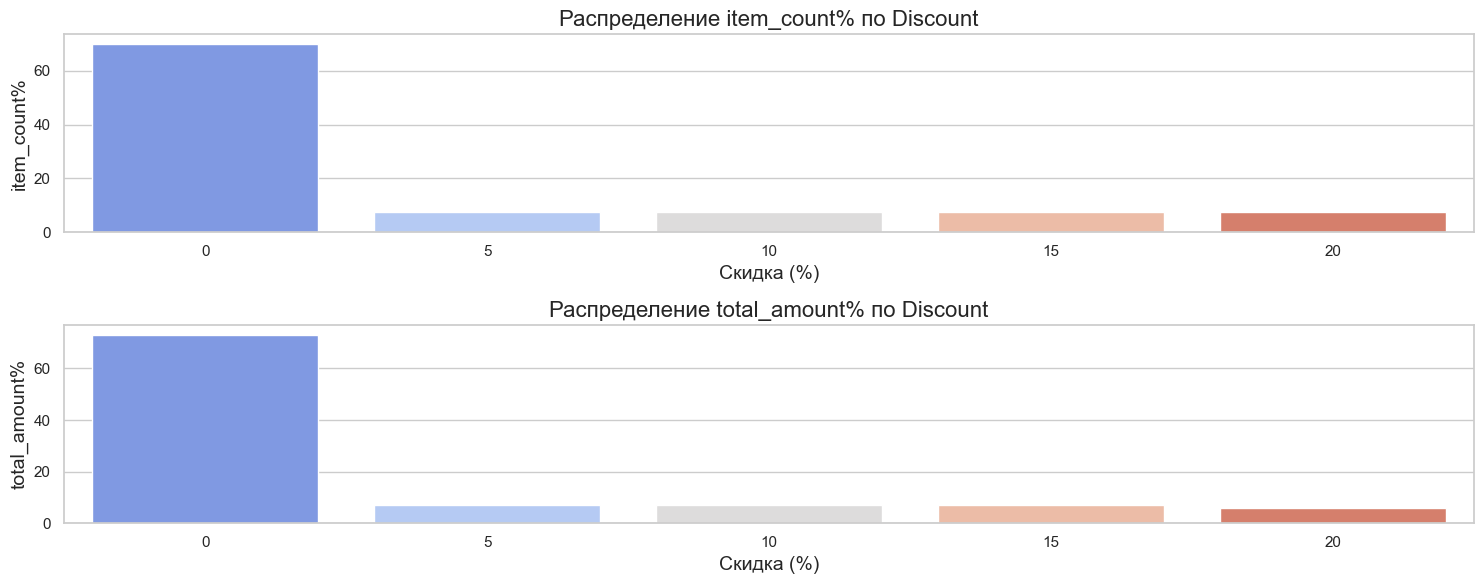

In [275]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

sns.barplot(x='Discount', y='item_count%', data=discount_data, ax=axes[0], palette="coolwarm")
axes[0].set_title('Распределение item_count% по Discount', fontsize=16)
axes[0].set_xlabel('Скидка (%)', fontsize=14)
axes[0].set_ylabel('item_count%', fontsize=14)

sns.barplot(x='Discount', y='total_amount%', data=discount_data, ax=axes[1], palette="coolwarm")
axes[1].set_title('Распределение total_amount% по Discount', fontsize=16)
axes[1].set_xlabel('Скидка (%)', fontsize=14)
axes[1].set_ylabel('total_amount%', fontsize=14)

plt.tight_layout()
plt.show()

- Большинство покупок совершается без скидок. Возможно, это связано с тем, что большинство товаров не участвуют в акциях, или покупатели не всегда мотивированы искать скидки.
- Скидочные товары равномерно распределены, но их доля в выручке незначительна по сравнению с товарами без скидок. Это говорит о том что в скидки - это не эффективно

---
## Топ Кассиров

In [276]:
cashier_stats =supermarket.groupby('Cashier') .agg(check_count=('ReceiptNumber', 'nunique'),total_amount=('Amount', 'sum')).reset_index()
cashier_stats['total_amount%'] = cashier_stats['total_amount'] / cashier_stats['total_amount'].sum() * 100
cashier_stats['total_amount%'] = cashier_stats['total_amount%'].round(2)
cashier_stats = cashier_stats.sort_values(by=['check_count'], ascending=False).head(5)

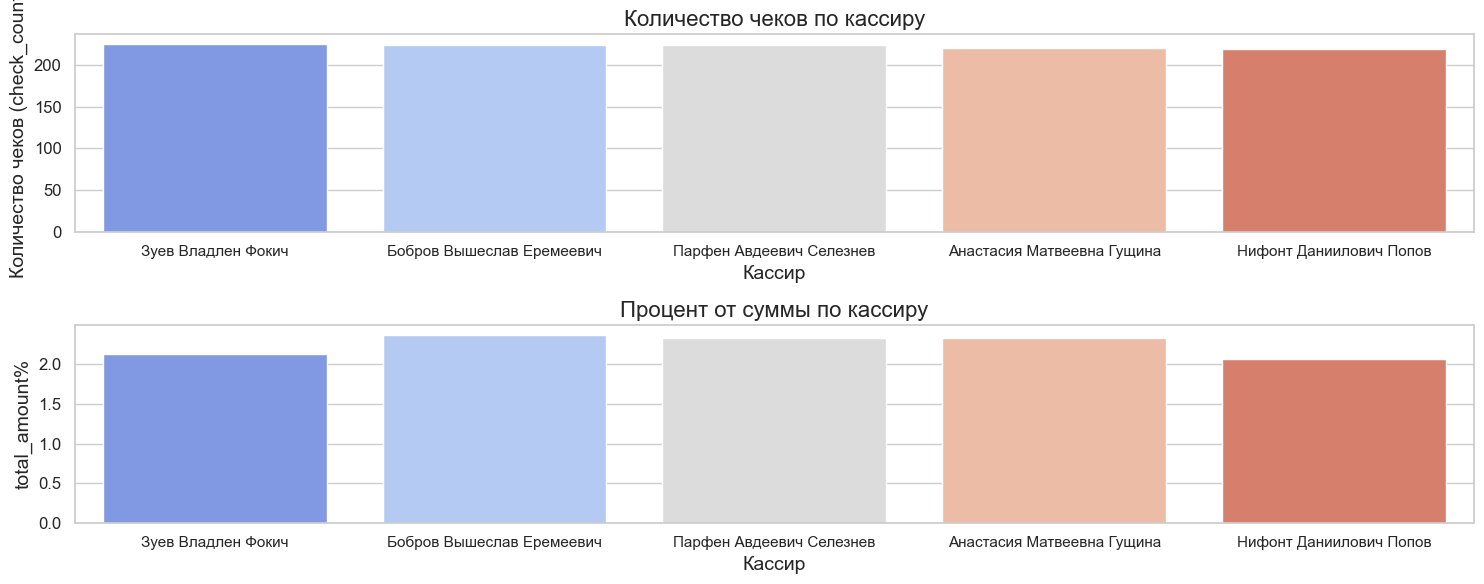

In [277]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

sns.barplot(x='Cashier', y='check_count', data=cashier_stats, ax=axes[0], palette="coolwarm")
axes[0].set_title('Количество чеков по кассиру', fontsize=16)
axes[0].set_xlabel('Кассир', fontsize=14)
axes[0].set_ylabel('Количество чеков (check_count)', fontsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.barplot(x='Cashier', y='total_amount%', data=cashier_stats, ax=axes[1], palette="coolwarm")
axes[1].set_title('Процент от суммы по кассиру', fontsize=16)
axes[1].set_xlabel('Кассир', fontsize=14)
axes[1].set_ylabel('total_amount%', fontsize=14)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

- Эффективность Боброва Вышеслава и Парфена Селезнева выделяется как по среднему чеку, так и по общей выручке. Они, вероятно, работают в часы пик или имеют навыки быстрого обслуживания покупателей с большими покупками.
- Зуев Владлен и Нифонт Попов могут быть задействованы в смены с меньшей активностью или работать с клиентами, совершающими покупки на небольшие суммы

---
## Анализ чеков

In [278]:
receipt_data = (supermarket.groupby('ReceiptNumber').agg(total_amount=('Amount', 'sum'), item_count=('Item', 'count')).reset_index())

In [279]:
bins = [15, 500, 1000, 1500, 2000, 2500, 3000]
labels = ['15-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000']
receipt_data['Amount_bin'] = pd.cut(receipt_data['total_amount'], bins=bins, labels=labels, right=False)
receipt_data

,ReceiptNumber,total_amount,item_count,Amount_bin
0,100001,612.219971,4,500-1000
1,100002,130.789993,1,15-500
2,100003,569.779968,3,500-1000
3,100004,1689.000000,4,1500-2000
4,100005,615.340027,4,500-1000
...,...,...,...,...
9995,109996,209.820007,3,15-500
9996,109997,381.640015,2,15-500
9997,109998,478.980011,4,15-500
9998,109999,847.380005,4,500-1000


In [280]:
bin_distribution = receipt_data['Amount_bin'].value_counts().sort_index()
bin_distribution

Amount_bin
15-500       5949
500-1000     2890
1000-1500     860
1500-2000     238
2000-2500      54
2500-3000       8
Name: count, dtype: int64

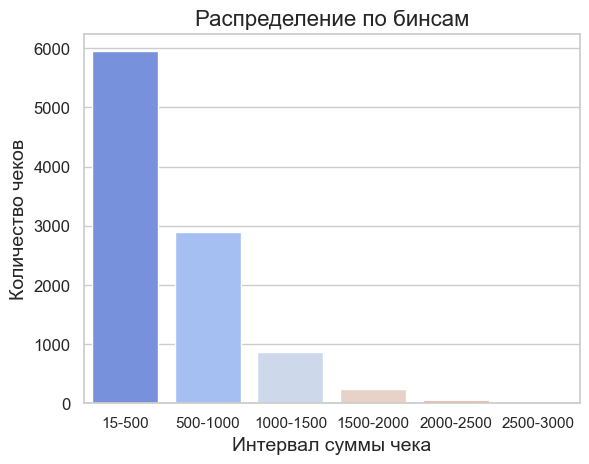

In [281]:
sns.barplot(x=bin_distribution.index, y=bin_distribution.values, palette="coolwarm")
plt.title('Распределение по бинсам', fontsize=16)
plt.xlabel('Интервал суммы чека', fontsize=14)
plt.ylabel('Количество чеков', fontsize=14)
plt.yticks(fontsize=12)

plt.show()

- Большинство покупателей предпочитают либо небольшие суммы (до 500), либо умеренные (500-1000).
Покупки на сумму более 1500 составляют менее 3% всех транзакций.

---


### Выводы и Рекомендации

**1. Количество чеков по датам:**
На графике с количеством чеков можно заметить, что количество транзакций во время некоторых периодов увеличивается. Это связано с увеличением потока покупателей в определенные дни. Если сравнить этот график с графиком сумм продаж, можно заметить, что в дни с высоким количеством чеков часто также наблюдается рост суммы продаж.

**2. Количество товаров по датам:**
Из графика, показывающего количество товаров по датам, видно, что количество товаров варьируется, но эти изменения не такие резкие. Это может означать, что покупатели чаще делают небольшие покупки, при этом продается большое количество товаров, но не всегда с высокими суммами. Например, в дни с высоким количеством товаров продажи могут быть связаны с продуктами с низкой ценой, но большим объемом (например, бананы, молоко).

**3. Количество чеков и товаров по дням недели:**
Графики показывают, что количество чеков и товаров остается довольно стабильным в течение недели, что свидетельствует о постоянном покупательском потоке. Это также подтверждает, что покупатели делают примерно одинаковое количество покупок вне зависимости от дня недели.

**4. Сезонность и влияние времени года:**
По сезонным данным мы можем наблюдать, что в осенние месяцы количество чеков значительно увеличивается, что может быть связано с сезонными покупками (например, товары для учебы, осенние коллекции одежды). Это позволяет планировать дополнительные маркетинговые усилия в этот период, чтобы извлечь выгоду из увеличенной покупательской активности.

**5. Популярность продуктов:**
Мы видим, что базовые продукты, такие как молоко, картофель и бананы, являются наиболее покупаемыми. Эти товары обеспечивают стабильный спрос и приносят значительную долю выручки, но они не влияют на большие суммы. В то время как премиальные товары, такие как кофе, чай или соки, хотя и менее популярны по количеству, имеют более высокий вклад в общую выручку, что может быть использовано для повышения доходности магазина. 

**6. Скидки:**
Большинство товаров продается без скидок, что является нормой для базовых товаров. Однако можно сделать вывод что скидки не оказывают значительного влияния на общий объем продаж и для повышения выручки необходимо искать другие методы.

**7. Кассы:**
По данным о кассах видно, что некоторые из них, такие как касса №5 и касса №6, имеют высокую нагрузку и обрабатывают больше чеков. Это может быть связано с их расположением в магазине, где покупатели проходят через них с высоко востребованными товарами. Например, касса №5, вероятно, обслуживает покупателей с чаем, а касса №6 — с бананами. Это также может указывать на необходимость оптимизации работы таких касс, улучшения их скорости обслуживания, а также возможного перемещения популярных товаров рядом с такими кассами для увеличения продаж.

---

## Рекомендации:

1. **Как сделать продажи:**
   - Нужно делать больше скидок на популярные товары, чтобы люди хотели покупать их чаще.
   - Можно подумать, как сделать товары с большими скидками более интересными. Может быть, их стоит поставить на видное место или делать акции с подарками.

2. **Расположение касс:**
   - Нужно проверить, где стоят кассы, и сделать так, чтобы самые популярные товары были рядом с кассами, чтобы они сразу привлекали внимание.

3. **Кассиры и их работа:**
   - Возможно, стоит обучить некоторых кассиров работать быстрее или помочь им в часы пик, чтобы они обслуживали больше людей и товаров. А также поощрять сотрудников с высокими показателями

---

## Проблемы, с которыми я столкнулась

### 1. **Нехватка времени**
     - Задание было предоставлено в выходные, а срок сдачи — до понедельника 6 вечера. Из-за этого не было достаточно времени для полноценного анализа, особенно для анализа анти-топов по переменным, проверки выбросов с использованием boxplot (которых, возможно не было бы в данных, так как они сгенерированы), а также для более глубокого анализа по сезонам. Также я хотела бы создать категории для продуктов и провести анализ по категориям, а также посмотреть чеки с большими и малыми суммами, также с чем чаще всего покупаются наиболее популярные продукты. 
     - Также хотела бы улучшить дизайн дашборда и графиков в представленом ноутбуке

### 2. **Качество данных**
     - В данных наблюдается корреляция почти равная нулю, что говорит что между переменными , почти нет связи что делает выводы анализа затруднительными
     - Несмотря на то, что продукт один и тот же цена у него не статично(не относятся ко скидкам)
     - Номер транзакции и номер чека по сути означают одно и то же для анализа.
     - Колонки "Организация" и "Артикул" не несут полезной информации для анализа, поскольку в данных только одна организация, а артикул не нужен, так как есть название товара, которое также уникально идентифицирует продукт.

### 3. **Мало данных**
      - Для более глубокого анализа можно добавить данные о покупателях (пол, возраст, локация), методах оплаты, товарных категориях, участии в акциях, возвратах, региональных трендах. Это позволит улучшить маркетинговые стратегии и персонализировать предложения для разных сегментов клиентов.